<a href="https://colab.research.google.com/github/gabyxsantos/Acidentes-de-Minas-Gerais-em-2020/blob/main/EstatMg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análise dos Acidentes de 2020 em Minas Gerais**

Atendendo à solicitação do cliente Leandro, este relatório analisa os dados de acidentes nas rodovias de Minas Gerais em 2020 para identificar as principais causas, padrões e pontos críticos.



In [ ]:
!pip install folium

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import locale
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from IPython.display import display, Markdown
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
url_dados = 'https://github.com/gabyxsantos/Acidentes-de-Minas-Gerais-em-2020/raw/refs/heads/main/Acidentes_2020.xlsx'
acidentes_2020 = pd.read_excel(url_dados)

##**Análise Descritiva**
Um dos primeiros passos para entender o problema em questão é ter uma noção geral dos dados que serão utilizados, para isso foram utilizadas algumas funções para promover uma breve, mas eficiente, visualização.

In [ ]:
#entendendo as colunas do df, vendo se elas são nulas ou não e também o tipo de cada uma.
acidentes_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      6536 non-null   int64         
 1   data_inversa            6536 non-null   datetime64[ns]
 2   dia_semana              6536 non-null   object        
 3   horario                 6536 non-null   object        
 4   uf                      6536 non-null   object        
 5   br                      6532 non-null   float64       
 6   km                      6532 non-null   float64       
 7   municipio               6536 non-null   object        
 8   tipo_acidente           6536 non-null   object        
 9   fase_dia                6536 non-null   object        
 10  condicao_metereologica  6536 non-null   object        
 11  tipo_pista              6536 non-null   object        
 12  pessoas                 6536 non-null   int64   

In [ ]:
#observação das 5 primeiras linhas dos nossos dados
acidentes_2020.head()

id data_inversa dia_semana   horario  uf     br     km     municipio  \
0  260067   2020-01-01     quarta  06:00:00  MG  381.0  671.5       PERDOES   
1  260073   2020-01-01     quarta  06:00:00  MG  262.0  804.0       UBERABA   
2  260075   2020-01-01     quarta  05:30:00  MG  381.0  548.5     RIO MANSO   
3  260078   2020-01-01     quarta  06:00:00  MG  381.0  325.0      NOVA ERA   
4  260108   2020-01-01     quarta  05:30:00  MG  459.0   94.8  POUSO ALEGRE   

               tipo_acidente   fase_dia  ... tipo_pista pessoas  mortos  \
0  Saída de leito carroçável  Pleno dia  ...      Dupla       4       0   
1        Colisão transversal  Pleno dia  ...      Dupla       4       0   
2                Capotamento  Amanhecer  ...      Dupla       1       0   
3  Saída de leito carroçável  Amanhecer  ...    Simples       1       0   
4           Colisão traseira  Amanhecer  ...    Simples       2       0   

   feridos_leves  feridos_graves  ilesos  feridos  veiculos   latitude  \
0              4               0       0        4         1 -21.089454   
1              1               0       3        1         2 -19.767475   
2              0               0       1        0         1 -20.310211   
3              1               0       0        1         1 -19.760996   
4              1               0       1        1         2 -22.184677   

   longitude  
0 -45.068642  
1 -47.987255  
2 -44.449931  
3 -43.036247  
4 -45.988678  

[5 rows x 21 columns]

##**Análise Geográfica**


###**Onde acontecem os acidentes?**
É importante considerar que, uma vez que estamos abordando os acidentes em MG, seria interessante, antes de qualquer análise mais detalhada, entender a distribuição dos acidentes no estado, conseguindo ter uma ideia visual de onde ocorreram.

Para isso, abaixo foi implementado um mapa iterativo, utilizando a biblioteca Folium, com a qual é possível plotar o mapa em branco e depois adicionar os pontos onde houveram acidentes.

Para melhorar a visualição e garantir que a representação não ficasse cheia e ilegível, foi utilizada a ideia de clausters, na qual os acidentes são agrupados em grupos, e a medida que se dá zoom, é possível ver cada vez mais grupos menores, encontrando as unidades dos acidentes, e evitando, com isso, sobrecarga de informações.

In [ ]:
df_mapa = acidentes_2020

In [ ]:
# Coordenadas aproximadas do centro de Minas Gerais e um bom nível de zoom inicial
coordenadas_mg = [-18.5122, -44.5550]
zoom_inicial = 6.5

# Recrie o mapa base (ou use o anterior, se preferir)
mapa_mg_cluster = folium.Map(location=coordenadas_mg, zoom_start=zoom_inicial, tiles='CartoDB positron')

# 1. Crie um objeto MarkerCluster e adicione ao mapa
marker_cluster = MarkerCluster().add_to(mapa_mg_cluster)


for index, acidente in df_mapa.iterrows():
    coords = [acidente['latitude'], acidente['longitude']]
    popup_texto = f"<b>Tipo:</b> {acidente['tipo_acidente']}<br><b>Município:</b> {acidente['municipio']}"

    folium.Marker(
        location=coords,
        popup=popup_texto,
    ).add_to(marker_cluster)

# Visualizar o mapa com clusters
mapa_mg_cluster

###**Quais são as BR's com mais acidentes?**
De todas as 16 Br's de Minas gerais, é interessante entender o top 5 destas, nas quais ocorreram mais acidentes.

In [ ]:
rodovias = acidentes_2020['br'].value_counts().head()

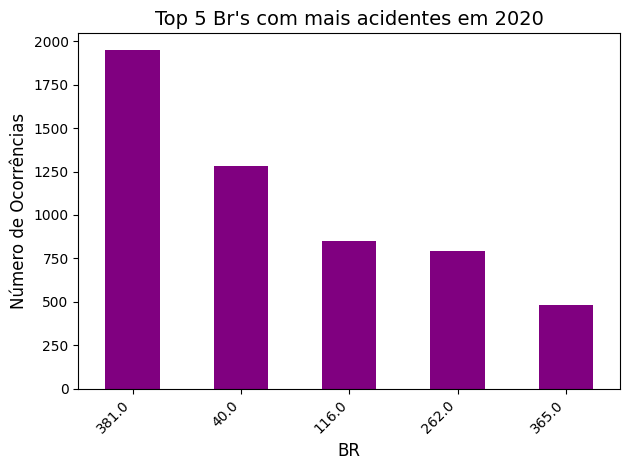

In [ ]:
rodovias.plot(kind = 'bar', color='purple')
plt.title("Top 5 Br's com mais acidentes em 2020", fontsize=14)
plt.xlabel('BR', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Dado isso, é de se pensar que, uma vez que essas rodovias são aquelas que contém um maior número de acidentes,  também seriam palco de acidentes graves e gravíssimos. Para analisar tal questão foi relevante dividir os casos:

**Acidente grave:** acidentes que deixaram feridos graves.

**Acidentes gravíssimos:** acidentes nos quais pessoas morreram.

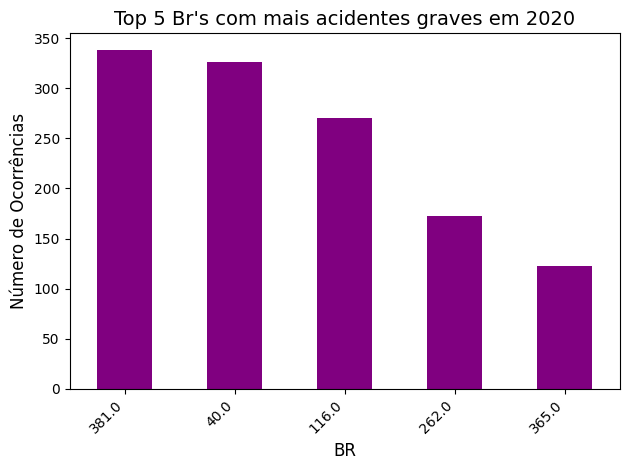

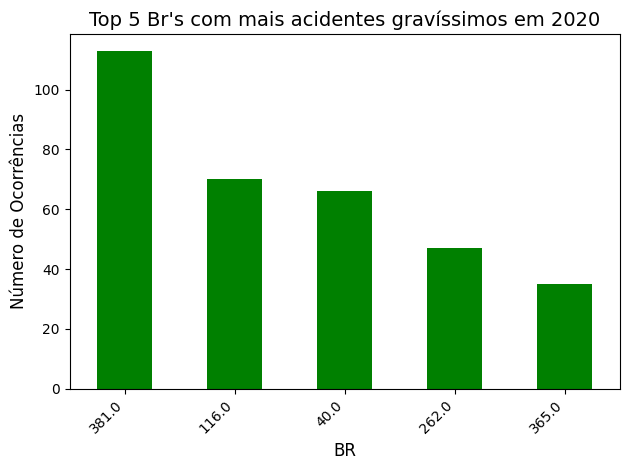

In [ ]:
#criando um df com os acidentes que resultaram em mortes e em feridos graves
acidentes_mortos = acidentes_2020[(acidentes_2020['mortos'] > 0)]
acidentes_graves = acidentes_2020[(acidentes_2020['feridos_graves'] > 0)]

#entendo a distribuição desses acidentes graves pelas Br's
acidentes_graves = acidentes_graves['br'].value_counts().head()
acidentes_mortos = acidentes_mortos['br'].value_counts().head()

#plotando os gráficos
acidentes_graves.plot(kind = 'bar', color='purple')
plt.title("Top 5 Br's com mais acidentes graves em 2020", fontsize=14)
plt.xlabel('BR', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

acidentes_mortos.plot(kind = 'bar', color='green')
plt.title("Top 5 Br's com mais acidentes gravíssimos em 2020", fontsize=14)
plt.xlabel('BR', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Como esperado, a ocorrência de acidentes graves e gravíssimos acontecem principalmente nas BR's com mais acidentes.

Entretanto, os grandes números são um indicativo de que é necessário entender essa situação, investigando causas e explicações, buscando, assim, poder promover políticas públicas que auxiliem à lidar com tal problema.

##**Análise Temporal**
Uma vez esclarecido *onde* ocorreram mais incidentes, é interessante entender *quando* eles ocorreram.

###**Distribuição Mensal**

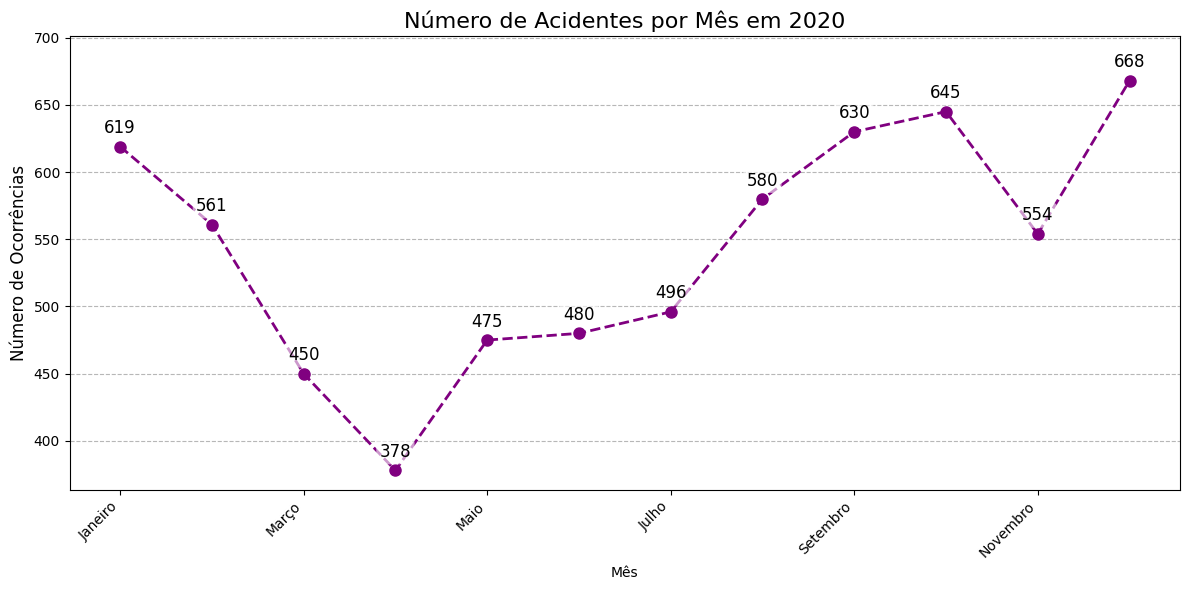

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

# Garante que a coluna 'data_inversa' está no formato de data
acidentes_2020['data_inversa'] = pd.to_datetime(acidentes_2020['data_inversa'])

# Cria a coluna com o NÚMERO do mês
acidentes_2020['mes'] = acidentes_2020['data_inversa'].dt.month

# Criamos o nosso "dicionário de tradução"
mapa_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

# Usa-se .map() para criar a coluna 'nome_mes' a partir do número do mês
acidentes_2020['nome_mes'] = acidentes_2020['mes'].map(mapa_meses)

# Contagem dos acidentes por mês
acidentes_por_mes = acidentes_2020['nome_mes'].value_counts()

# Criamos uma lista com a ordem correta para o gráfico
ordem_cronologica = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                     'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# Reordenando os dados para que fiquem na ordem certa
acidentes_por_mes_ordenado = acidentes_por_mes.reindex(ordem_cronologica)

# Plotando os dados já ordenados
acidentes_por_mes_ordenado.plot(kind='line',
                                color='purple',
                                figsize=(12, 6),
                                marker='o',
                                markersize=8,
                                linewidth=2,
                                linestyle='--' )

for index, valor in enumerate(acidentes_por_mes_ordenado):
    ax.text(
        index,
        valor + 10,
        str(valor),
        ha='center',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')

    )

plt.title('Número de Acidentes por Mês em 2020', fontsize=16)
plt.xlabel('Mês', fontsize=10)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.9)

valor_maximo = acidentes_por_mes_ordenado.max()
ax.set_ylim(top=valor_maximo * 1.05)

plt.tight_layout()
plt.show()

Por meio deste resultado, é notório que os dados fogem do esperado, uma vez que, meses festivos ou de férias escolares já tendem a ter mais acidentes, o que é algo de conhecimento comum, porém **OUTUBRO** e **SETEMBRO** de 2020 terem um índice tão alto de acidentes é, no mínimo, curioso.

Para entender melhor esse acontecimento, é necessário relembrar o contexto global vivenciado no ano de 2020, a Pandemia de Covid-19. Nessa temática, os dados em questão contam uma história do ano:

* **Janeiro (Pré-Pandemia):** Este faz sentido. Janeiro é tradicionalmente um mês de férias de verão, com tráfego intenso. O ano começou "normal".
* **A Grande Queda (Março-Junho):** Como observado no gráfico, esses meses apresentaram os menores números de acidentes, mas por quê? Foi o auge do lockdown e das medidas de restrição mais severas. As pessoas ficaram em casa, as rodovias esvaziaram.
* **Agosto, Setembro e Outubro (A Flexibilização e a "Fadiga do Lockdown"):** Após meses de restrições, as medidas começaram a ser flexibilizadas no segundo semestre. As pessoas estavam ansiosas para viajar, mesmo que para perto ("turismo de proximidade"). Além disso, contêm feriados prolongados importantes (7 de Setembro, 12 de Outubro). Com as viagens aéreas ainda em baixa, as pessoas optaram massivamente pelo carro. Esses feriados podem ter tido um fluxo de veículos nas estradas maior do que em anos normais.


###**Análise Diária:**

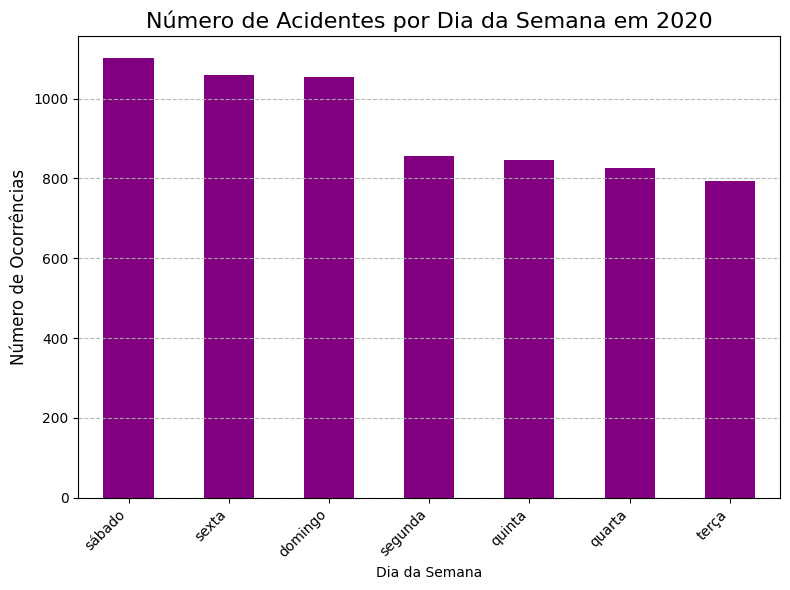

In [ ]:
acidentes_dia = acidentes_2020['dia_semana'].value_counts()
acidentes_dia.plot(kind = 'bar', color='purple', figsize=(8, 6))
plt.title('Número de Acidentes por Dia da Semana em 2020', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=10)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

### **A Diferença no Volume de Acidentes é Significativa?**

A análise descritiva anterior, por meio do gráfico de barras, sugeriu um aumento considerável no volume de acidentes durante o fim de semana (Sexta, Sábado e Domingo) em comparação com os dias úteis. Contudo, essa diferença observada é **estatisticamente significativa** ou poderia ser apenas uma flutuação aleatória dos dados?

Para responder a essa pergunta com rigor estatístico, será adotada uma abordagem em duas etapas:

1.  **Teste ANOVA (Análise de Variância):** Primeiramente, será aplicado o teste ANOVA de 1 Fator para comparar as médias de acidentes diários entre os sete dias da semana. Este teste dirá **SE** existe uma diferença significativa em pelo menos um dos grupos.
    * **$H_0$ (Hipótese Nula):** As médias de acidentes diários são iguais para todos os dias da semana.
    * **$H_1$ (Hipótese Alternativa):** Pelo menos uma das médias de acidentes diários é diferente das outras.

2.  **Teste Post-Hoc de Tukey HSD:** Caso a ANOVA indique um resultado significativo (rejeitando $H_0$), ela nos informa que existe uma diferença, mas não aponta *onde*. Para identificar **QUAIS** pares de dias (ex: Sábado vs. Segunda) são especificamente diferentes entre si, será conduzido o teste post-hoc de Tukey HSD.

Essa abordagem permitirá não apenas confirmar a existência de um padrão, mas também detalhar sua natureza com alta confiança estatística.

In [ ]:
# Preparar os dados (sem mudanças aqui)
acidentes_por_dia = acidentes_2020.groupby(
    [acidentes_2020['data_inversa'].dt.date, 'dia_semana']
).size().reset_index(name='contagem_acidentes')
acidentes_por_dia.rename(columns={'data_inversa': 'data'}, inplace=True)

#criando ums lista com as categorias
lista_de_dias_correta = acidentes_por_dia['dia_semana'].unique()


# Criar os dados para o teste usando a lista criada
dados_para_anova = [acidentes_por_dia[acidentes_por_dia['dia_semana'] == dia]['contagem_acidentes'] for dia in lista_de_dias_correta]


#  Executar o Teste ANOVA
stat_anova, p_valor_anova = f_oneway(*dados_para_anova)

print("\n--- 1. Resultado do Teste ANOVA ---")
print(f"Estatística F: {stat_anova:.2f}")
print(f"P-valor: {p_valor_anova:.5f}")


# Executar o Teste Post-Hoc de Tukey
if pd.notna(p_valor_anova) and p_valor_anova < 0.05:
    print("\nComo o p-valor da ANOVA é significativo, prosseguimos com o Teste de Tukey.")

    dados_tukey = acidentes_por_dia['contagem_acidentes']
    grupos_tukey = acidentes_por_dia['dia_semana']

    tukey_resultado = pairwise_tukeyhsd(endog=dados_tukey, groups=grupos_tukey, alpha=0.05)

    print("\n--- 2. Resultado do Teste Post-Hoc de Tukey HSD ---")
    print(tukey_resultado)
else:
    print("\nComo o p-valor da ANOVA não é significativo (ou é inválido), a análise para aqui.")


--- 1. Resultado do Teste ANOVA ---
Estatística F: 10.98
P-valor: 0.00000

Como o p-valor da ANOVA é significativo, prosseguimos com o Teste de Tukey.

--- 2. Resultado do Teste Post-Hoc de Tukey HSD ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
domingo  quarta   -4.684 0.0006 -7.9662 -1.4017   True
domingo  quinta  -4.2877 0.0024   -7.57 -1.0055   True
domingo segunda  -3.7692 0.0136 -7.0671 -0.4714   True
domingo   sexta   0.1154    1.0 -3.1824  3.4132  False
domingo  sábado   0.9423 0.9797 -2.3555  4.2401  False
domingo   terça  -4.9808 0.0002 -8.2786 -1.6829   True
 quarta  quinta   0.3962 0.9998 -2.8703  3.6628  False
 quarta segunda   0.9147 0.9821 -2.3675   4.197  False
 quarta   sexta   4.7993 0.0004  1.5171  8.0816   True
 quarta  sábado   5.6263    0.0   2.344  8.9085   True
 quarta   terça  -0.2968    1.0  -3.579  2.9854  False
 quinta segunda   0.5185 

### Interpretação dos Resultados e Conclusões

O teste ANOVA resultou em um p-valor de **0.0000**, valor significativamente inferior ao nível de significância de 0.05. Este resultado permitiu rejeitar a hipótese nula e confirmar que existe, de fato, uma diferença estatisticamente significativa na média de acidentes entre os dias da semana.

A análise post-hoc de Tukey HSD, detalhada na tabela de resultados acima, aprofunda essa descoberta ao comparar cada par de dias. A partir da coluna `reject`, podemos extrair as seguintes conclusões principais:

* **Grupo de Alto Risco (Fim de Semana Estendido):** Sexta-feira, Sábado e Domingo apresentaram médias de acidentes diários **estatisticamente superiores** às de Segunda, Terça, Quarta e Quinta-feira (todas as comparações com `reject = True`).

* **Consistência no Fim de Semana:** As comparações *entre* Sexta-feira, Sábado e Domingo **não mostraram diferenças estatisticamente significativas** entre si (coluna `reject = False`). Isso sugere que esses três dias formam um bloco coeso de alto risco.

* **Grupo de Risco Moderado (Dias Úteis):** Da mesma forma, não foram encontradas diferenças significativas *entre* os dias de Segunda a Quinta-feira, consolidando-os como um grupo de risco mais baixo e homogêneo.

**Conclusão Final:**
Portanto, a análise estatística valida e quantifica a observação inicial: os dias da semana, no que tange à frequência de acidentes, dividem-se em **dois grupos de risco distintos**. O período que se inicia na **Sexta-feira e se estende até o Domingo** representa uma fase de perigo acentuadamente e significativamente maior nas rodovias, reforçando a necessidade de estratégias de prevenção e fiscalização focadas neste período.

###**Análise por horário:**

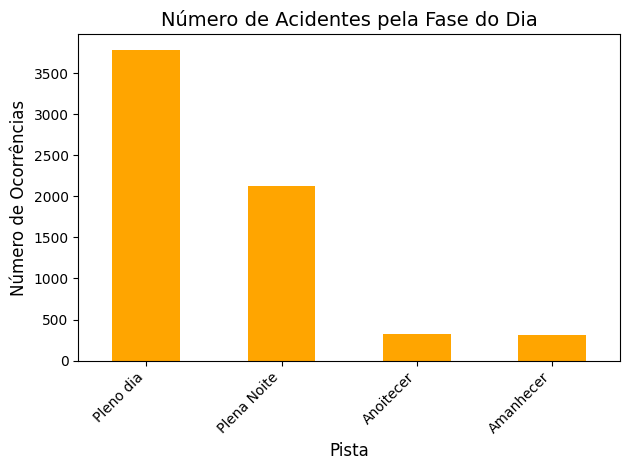

In [ ]:
#análise pela fase do dia
fase = acidentes_2020['fase_dia'].value_counts()
fase.plot(kind='bar', color='orange')
plt.title("Número de Acidentes pela Fase do Dia", fontsize=14)
plt.xlabel('Pista', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

O gráfico resultante expõe um resultado considerado esperado, de que a maioria dos acidenetes ocorrem em pleno dia ou plena noite.

##**Fatores e Causas:**
Seguindo na análise do dataset, agora o foco será em entender algumas das variáveis que podem estar relacionadas aos acidentes e, posteriormente, entender se realmente existe alguma relação.

###**Análise Descritiva dos Fatores:**
Gráficos de barras simples mostrando a distribuição por tipo_pista, condicao_metereologica e por tipo_acidente.

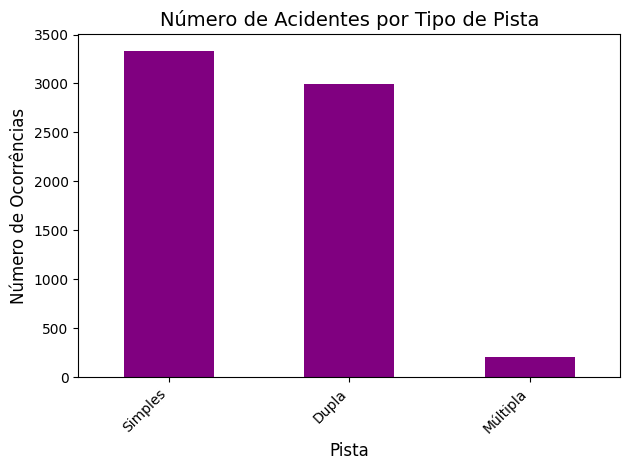

In [ ]:
#análise pelo tipo de pista
pista = acidentes_2020['tipo_pista'].value_counts()
pista.plot(kind='bar', color='purple')
plt.title("Número de Acidentes por Tipo de Pista", fontsize=14)
plt.xlabel('Pista', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

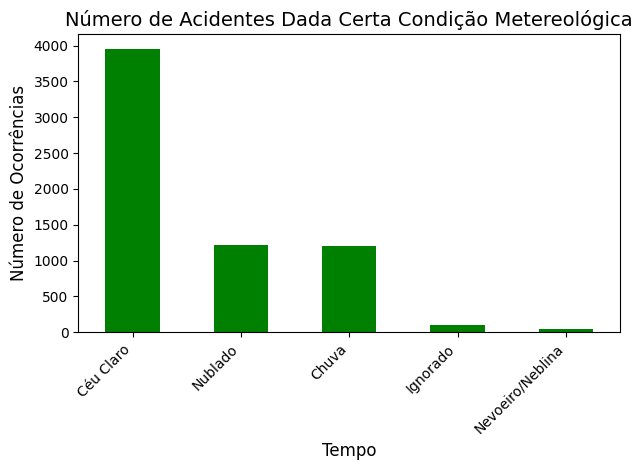

In [ ]:
#análise pela condição metereológica
tempo = acidentes_2020['condicao_metereologica'].value_counts()
tempo.plot(kind='bar', color='green')
plt.title("Número de Acidentes Dada Certa Condição Metereológica", fontsize=14)
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

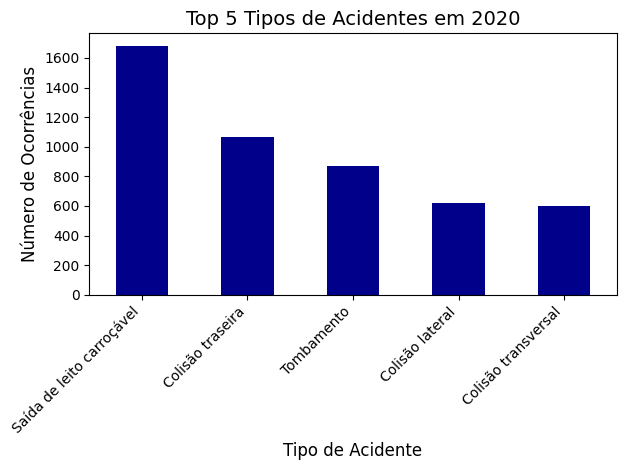

In [ ]:
#análise dos tipos de acidentes
causas_principais = acidentes_2020.groupby('tipo_acidente')['id'].count().sort_values(ascending=False).head(5)
causas_principais.plot(kind = 'bar', color='DarkBlue')
plt.title('Top 5 Tipos de Acidentes em 2020', fontsize=14)
plt.xlabel('Tipo de Acidente', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

###**Análise de Associações:**


####**A condição meteorológica está associada ao tipo de acidente?**
É **intuitivo** supor que as condições **meteorológicas** podem influenciar na ocorrência de acidentes, mas será que elas influenciam no **tipo** de acidente que ocorreu?

Para entender isso, será utilizado o seguinte passo a passo:
**Cross-table -> HeatMap -> Teste de Qui-Quadrado**

Ou seja, nosso objetivo é entender se existe alguma relação entre os tipos de acidente e a condição meteorológica no momento do ocorrido, ou se tudo se deve ao acaso.

Para isso, a **tabela de contingência** monta uma estrutura com as frequências observadas.

Para obter uma melhor visualização desta tabela, o **HeatMap** será plotado, que por ser um mapa de calor facilita a compreenssão dos padrões. Depois, para avaliar se as variáveis estão associadas ou se qualquer discrepância ou padrão curioso na tabela é fruto do acaso, usa-se o **teste Qui-Quadrado**.

* Inicialmente, foi gerado um mapa de calor (heatmap) a partir da tabela de contingência com as contagens totais de acidentes. A análise deste primeiro gráfico revela que a maioria dos acidentes, independentemente do tipo, ocorre sob a condição de "Céu Claro". Este achado estabelece o cenário de maior volume, indicando que as estratégias de mitigação devem, em grande parte, considerar as condições de tempo bom devido à alta frequência de ocorrências.

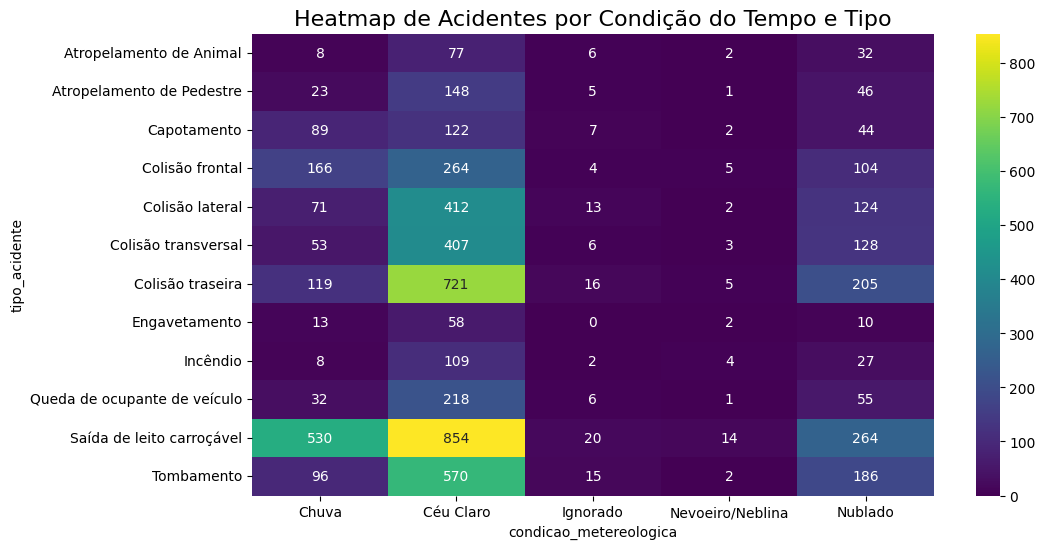

In [ ]:
#criando uma tabela de contingência


tabela_tempo = pd.crosstab(
    index=acidentes_2020['condicao_metereologica'],
    columns=acidentes_2020['tipo_acidente'],
)
inversa = tabela_tempo.T

plt.figure(figsize=(11, 6))
sns.heatmap(
    inversa,
    annot=True,
    fmt='d',            # Formata os números como inteiros
    cmap='viridis'
)
plt.title('Heatmap de Acidentes por Condição do Tempo e Tipo', fontsize=16)
plt.show()

* No entanto, a análise de volumes absolutos não é suficiente para determinar se o perfil de risco se altera com as condições do tempo. Para aprofundar a investigação, foi necessário analisar as proporções relativas. Para isso, a tabela de contingência foi normalizada por condição meteorológica, de modo que cada coluna somasse 100%.

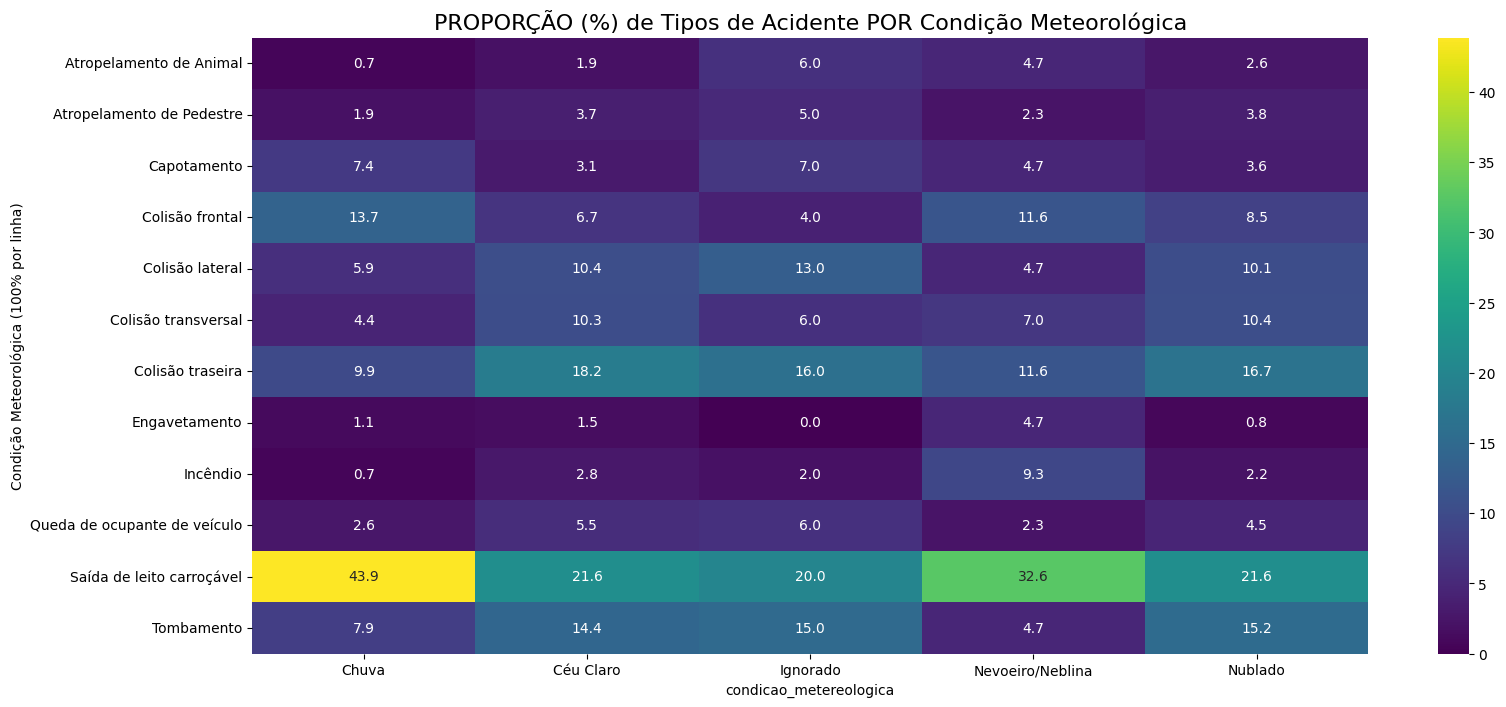

In [ ]:
# 1. Crie a tabela de contingência normalizada por linha ('index')
# normalize='index' faz com que a soma de cada linha seja 1 (ou 100%)
tabela_normalizada = pd.crosstab(
    index=acidentes_2020['condicao_metereologica'],
    columns=acidentes_2020['tipo_acidente'],
    normalize='index'
) * 100 # Multiplica por 100 para ver em porcentagem

# 2. Plote o heatmap com essa nova tabela de proporções
plt.figure(figsize=(18, 8))
sns.heatmap(
    (tabela_normalizada.T),
    annot=True,
    fmt='.1f', # Formata para mostrar uma casa decimal (ex: 15.2%)
    cmap='viridis'
)
plt.title('PROPORÇÃO (%) de Tipos de Acidente POR Condição Meteorológica', fontsize=16)
plt.ylabel('Condição Meteorológica (100% por linha)')
plt.show()

* O mapa de calor resultante desta tabela normalizada expõe uma nova e crucial perspectiva. Observa-se que, embora o número total de acidentes na chuva seja menor, a proporção de acidentes do tipo "Colisão Frontal", por exemplo, aumenta de forma acentuada neste cenário, representando uma porcentagem significativamente maior do total de ocorrências em dias chuvosos em comparação com dias de céu claro.

Para validar formalmente essa associação visual, foi conduzido o **Teste Qui-Quadrado** de Independência, testando as seguintes hipóteses:

**H0:** As variáveis "Condição Meteorológica" e "Tipo de Acidente"  são independentes. Não existe uma associação real entre elas. O perfil dos tipos de acidente é o mesmo, não importa se está chovendo, com neblina ou com céu claro. Qualquer padrão que vemos no heatmap é apenas uma coincidência.

**H1:** As variáveis "Condição Meteorológica" e "Tipo de Acidente"  são dependentes. Existe uma associação real entre elas. Ou seja, a condição do tempo influencia o tipo de acidente que é mais provável de ocorrer.

In [ ]:
#executando o teste
qui2, p_valor, graus_liberdade, freqs_esperadas = chi2_contingency(tabela_tempo)

#resultado:
print("--- Resultado do Teste Qui-Quadrado ---")
print(f"Estatística Qui-Quadrado (χ²): {qui2:.2f}")
print(f"Graus de Liberdade: {graus_liberdade}")
print(f"P-valor: {p_valor:.5f}") # Usando mais casas decimais para ver se é muito pequeno

alpha = 0.05 # nível de significância
print(f"\nNível de significância (α): {alpha}")

--- Resultado do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 519.57
Graus de Liberdade: 44
P-valor: 0.00000

Nível de significância (α): 0.05


Este resultado leva à **rejeição da hipótese nula**, permitindo concluir com **95%** de confiança que a associação entre a condição meteorológica e o tipo de acidente é **estatisticamente significativa**. Portanto, os padrões observados não são fruto do acaso. Fica evidente que a condição do tempo não apenas influencia a quantidade, mas também impacta na chance de um determinado tipo acontecer.

####**O tipo de pista está associado à gravidade do acidente?**



Para testar essa possível associação e possibilitar a utilização do teste **Qui-Quadrado** em seguida, foi necessário criar uma nova classificação na tabela, a de **Gravidade dos acidentes**. Para tal, foi estabelecido o seguinte parâmetro:
* **Gravíssimo:** acidenetes com mortos
* **Grave:** acidentes com feridos graves
* **Leve:** acidentes com feridos leves
* **Sem Vítimas Feridas:** como o nome diz, acidentes sem feridos

In [ ]:
#criando as condições na ordem que devem ser avaliadas (são excludenets entre si)
condicoes = [
    acidentes_2020['mortos'] > 0,
    acidentes_2020['feridos_graves'] > 0,
    acidentes_2020['feridos_leves'] > 0,
    acidentes_2020['ilesos'] > 0
]

# Defindo os resultados para cada condição
opcoes = ['Gravissimo', 'Grave', 'Leve', 'Sem Vítimas Feridas']

# Usa-se np.select para criar a coluna.
acidentes_2020['gravidade'] = np.select(condicoes, opcoes, default='Não Informado')

print("Coluna 'gravidade' criada com sucesso!")
print(acidentes_2020['gravidade'].value_counts())

Coluna 'gravidade' criada com sucesso!
gravidade
Leve                   3930
Grave                  1384
Sem Vítimas Feridas     805
Gravissimo              417
Name: count, dtype: int64


In [ ]:
tabela_pista_gravidade = pd.crosstab(
    index=acidentes_2020['tipo_pista'],
    columns=acidentes_2020['gravidade']
)

# Reordenando as colunas de gravidade para uma ordem lógica
ordem_gravidade = ['Sem Vítimas Feridas', 'Leve', 'Grave', 'Fatal']
colunas_presentes = [col for col in ordem_gravidade if col in tabela_pista_gravidade.columns]
tabela_pista_gravidade = tabela_pista_gravidade[colunas_presentes]

tabela_pista_gravidade

gravidade   Sem Vítimas Feridas  Leve  Grave
tipo_pista                                  
Dupla                       418  1933    514
Múltipla                     19   155     31
Simples                     368  1842    839

* Para esta análise, optou-se por um gráfico de barras empilhadas 100%. Esta visualização garante uma comparação mais justa dos resultados, uma vez que o objetivo é entender se a proporção da gravidade dos acidentes se altera de acordo com o tipo de pista. Analisar apenas os números absolutos poderia levar a conclusões enganosas. Por exemplo, o número total de acidentes fatais pode ser maior em 'Pista Simples' simplesmente porque há um volume maior de acidentes nesse tipo de via. O gráfico de proporções, por outro lado, revela o risco relativo de cada tipo de pista, mostrando qual delas tem uma 'fatia' percentualmente maior de acidentes graves ou fatais.

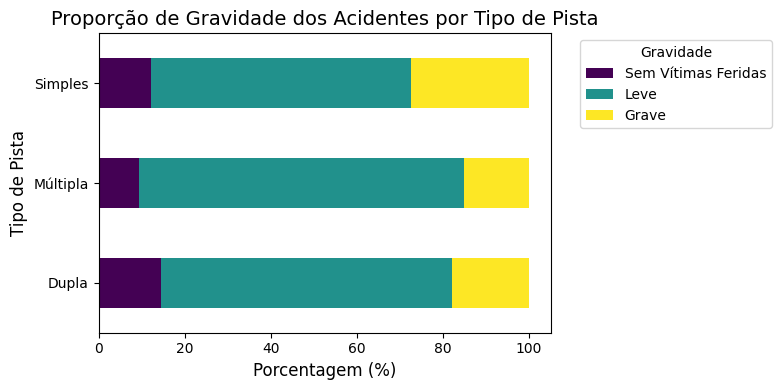

In [ ]:
# Normalizando a tabela para que cada linha some 100%
tabela_proporcional = tabela_pista_gravidade.div(tabela_pista_gravidade.sum(axis=1), axis=0) * 100

# Plotando
ax = tabela_proporcional.plot(
    kind='barh', # Gráfico de barras horizontais, fica bom para ler os rótulos
    stacked=True,
    figsize=(8, 4),
    colormap='viridis'
)

ax.set_title('Proporção de Gravidade dos Acidentes por Tipo de Pista', fontsize=14)
ax.set_xlabel('Porcentagem (%)', fontsize=12)
ax.set_ylabel('Tipo de Pista', fontsize=12)
plt.legend(title='Gravidade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

O próximo passo é realizar o teste, para observar se existe ou não associação:

* **H0:** Não existe associação entre o tipo de pista e a gravidade do acidente.
* **H1:** Existe associação entre o tipo de pista e a gravidade do acidente.

In [ ]:
qui2, p_valor, _, _ = chi2_contingency(tabela_pista_gravidade)

print(f"\nP-valor do Teste Qui-Quadrado: {p_valor:.5f}")




P-valor do Teste Qui-Quadrado: 0.00000


* **Conclusão:** Uma vez que o resultado do p-valor foi igual a zero, com um nível de 5% de significância, tem-se evidências para rejeitar **H0**, ou seja, existe sim uma relação entre as variáveis **tipo de pista** e **gravidade**.

##**Estudo de caso:**
Considerando que a Br 381 e a Br 040 são aquelas com mais acidentes, é interessante investigar se existem "Hotspots" nessas rodovias.

###**BR 381**

A proposta aqui é identificar se existe algum KM da Br 381 que contou com mais acidentes em 2020. Em caso afirmatico, realizar uma análise aprofundade de tal local.

In [ ]:
br381 = acidentes_2020[acidentes_2020['br'] == 381].copy()
br381.rename(columns={'km': 'km_381'}, inplace=True)

contagem_por_km = br381.groupby('km_381')['id'].count()

contagem_por_km = contagem_por_km.reset_index(name ='Num_Acidentes')
contagem_por_km.sort_values(by='Num_Acidentes', ascending = False).head(1)

km_381  Num_Acidentes
424   490.0             14

Após a identificação dos quilômetros com maior frequência de acidentes, foi realizada uma análise aprofundada no ponto mais crítico: o **KM 490.0**, que registrou **14** acidentes em 2020.

In [ ]:
df_hotspot_detalhes = br381[br381['km_381'] == 490]
tipos_acidente_hotspot = df_hotspot_detalhes['tipo_acidente'].value_counts()

print("\n--- Perfil dos Acidentes no Hotspot (KM 490.0) ---")
display(Markdown('**Tipos de Acidente Mais Comuns:**'))
print(tipos_acidente_hotspot)
print('\n')

# --- Análise do Tipo de Pista no hotspot ---
tipos_pista_hotspot = df_hotspot_detalhes['tipo_pista'].value_counts()
display(Markdown('**Características da Via no Ponto do Hotspot:**'))
print(tipos_pista_hotspot)
print('\n')

# --- Análise Extra: Fase do Dia ---
fase_dia_hotspot = df_hotspot_detalhes['fase_dia'].value_counts()

display(Markdown('**Período do Dia com Mais Ocorrências no Hotspot:**'))
print(fase_dia_hotspot)


--- Perfil dos Acidentes no Hotspot (KM 490.0) ---


**Tipos de Acidente Mais Comuns:**

tipo_acidente
Colisão traseira             7
Tombamento                   2
Colisão transversal          1
Atropelamento de Pedestre    1
Capotamento                  1
Incêndio                     1
Colisão lateral              1
Name: count, dtype: int64




**Características da Via no Ponto do Hotspot:**

tipo_pista
Dupla       10
Múltipla     4
Name: count, dtype: int64




**Período do Dia com Mais Ocorrências no Hotspot:**

fase_dia
Pleno dia      6
Plena Noite    5
Anoitecer      2
Amanhecer      1
Name: count, dtype: int64


**Hipótese Conclusiva:** A alta concentração de colisões traseiras em um trecho de pista dupla durante o dia sugere fortemente que o KM 490.0 é um ponto de congestionamento crônico. A causa provável não é a periculosidade da geometria da via (curvas fechadas, etc.), mas sim o alto fluxo e a falta de distância segura entre os veículos, característico do efeito 'anda-e-para' em trechos urbanizados ou próximos a acessos de cidades, radares e pedágios.

Uma verificação no Google Maps para o KM 490 da BR-381 confirma que este trecho está localizado na densa área urbana de Betim, próximo a múltiplos acessos e com alto fluxo de veículos pesados, o que corrobora nossa hipótese.

###**BR 040**

In [ ]:
br040 = acidentes_2020[acidentes_2020['br'] == 40].copy()
br040.rename(columns={'km': 'km_040'}, inplace=True)

contagem_por_km = br040.groupby('km_040')['id'].count()

contagem_por_km = contagem_por_km.reset_index(name ='Num_Acidentes')
contagem_por_km.sort_values(by='Num_Acidentes', ascending = False).head(1)

km_040  Num_Acidentes
381   511.0             17

Após a identificação dos quilômetros com maior frequência de acidentes, foi realizada uma análise aprofundada no ponto mais crítico: o **KM 511.0**, que registrou **16** acidentes em 2020.

In [ ]:
df_hotspot_detalhes = br040[br040['km_040'] == 511]
tipos_acidente_hotspot = df_hotspot_detalhes['tipo_acidente'].value_counts()

print("\n--- Perfil dos Acidentes no Hotspot (KM 511.0) ---")
display(Markdown('**Tipos de Acidente Mais Comuns:**'))
print(tipos_acidente_hotspot)
print('\n')

# --- Análise do Tipo de Pista no hotspot ---
tipos_pista_hotspot = df_hotspot_detalhes['tipo_pista'].value_counts()
display(Markdown('**Características da Via no Ponto do Hotspot:**'))
print(tipos_pista_hotspot)
print('\n')

# --- Análise Extra: Fase do Dia ---
fase_dia_hotspot = df_hotspot_detalhes['fase_dia'].value_counts()

display(Markdown('**Período do Dia com Mais Ocorrências no Hotspot:**'))
print(fase_dia_hotspot)


--- Perfil dos Acidentes no Hotspot (KM 511.0) ---


**Tipos de Acidente Mais Comuns:**

tipo_acidente
Colisão traseira             6
Tombamento                   4
Colisão lateral              3
Atropelamento de Pedestre    2
Saída de leito carroçável    2
Name: count, dtype: int64




**Características da Via no Ponto do Hotspot:**

tipo_pista
Dupla    17
Name: count, dtype: int64




**Período do Dia com Mais Ocorrências no Hotspot:**

fase_dia
Pleno dia      10
Plena Noite     6
Anoitecer       1
Name: count, dtype: int64


**Hipótese conclusiva:** o KM 511 da BR-040 funciona como um "gargalo de tráfego complexo". A alta incidência de acidentes é, possivelmente, causada pela interação perigosa entre o tráfego pesado de caminhões que servem à CEASA e o tráfego de veículos leves, exacerbada por um desenho viário com múltiplas entradas e saídas que forçam constantes manobras e geram grande diferencial de velocidade.